In [0]:
! wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip'
! wget 'http://nlp.stanford.edu/data/glove.6B.zip'
! unzip glove.6B.zip
! unzip 'sentiment labelled sentences.zip'
! mv /content/'sentiment labelled sentences'/ /content/data
! mkdir data/sentiment_analysis
! mv data data/sentiment_analysis

mkdir: cannot create directory ‘data/sentiment_analysis’: File exists
mv: cannot move 'data' to a subdirectory of itself, 'data/sentiment_analysis/data'


In [0]:
! mv glove.6B.50d.txt data/glove.6B.50d.txt

In [0]:
! ls

 data		     glove.6B.300d.txt	 sample_data
 glove.6B.100d.txt   glove.6B.zip	'sentiment labelled sentences.zip'
 glove.6B.200d.txt   __MACOSX


In [0]:
import pandas as pd

filepath_dict = {'yelp':   'data/sentiment_analysis/yelp_labelled.txt',
                 'amazon': 'data/sentiment_analysis/amazon_cells_labelled.txt',
                 'imdb':   'data/sentiment_analysis/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.head())

                                            sentence  label source
0                           Wow... Loved this place.      1   yelp
1                                 Crust is not good.      0   yelp
2          Not tasty and the texture was just nasty.      0   yelp
3  Stopped by during the late May bank holiday of...      1   yelp
4  The selection on the menu was great and so wer...      1   yelp


In [0]:
from sklearn.model_selection import train_test_split

df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, y, test_size=0.25, random_state=1000)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train


<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

In [0]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(solver= 'lbfgs')
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.796


In [0]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    classifier = LogisticRegression(solver= 'lbfgs')
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


In [0]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 10)                17150     
_________________________________________________________________
dense_104 (Dense)            (None, 1)                 11        
Total params: 17,161
Trainable params: 17,161
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Training Accuracy: 1.0000
Testing Accuracy:  0.7701


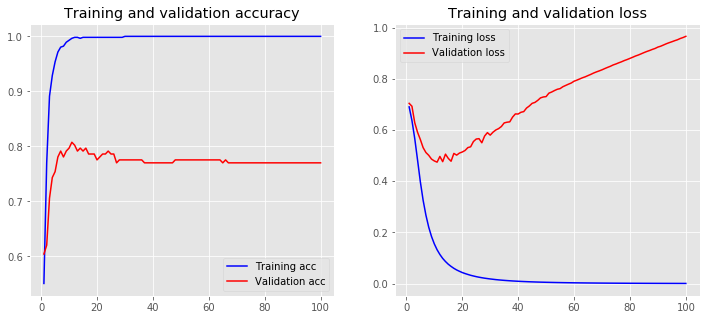

In [0]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

In [0]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])


Of all the dishes, the salmon was the best, but all were great.
[11, 43, 1, 171, 1, 283, 3, 1, 47, 26, 43, 24, 22]


In [0]:
for word in ['the', 'all', 'me', 'you']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 43
me: 75
you: 29


In [0]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
print(X_train[0, :])

[  1  10   3 282 739  25   8 208  30  64 459 230  13   1 124   5 231   8
  58   5  67   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


4603


In [0]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50
model = Sequential()
model.add(layers.Embedding(input_dim= vocab_size, 
                           output_dim= embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_51 (Embedding)     (None, 100, 50)           87350     
_________________________________________________________________
flatten_4 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_105 (Dense)            (None, 10)                50010     
_________________________________________________________________
dense_106 (Dense)            (None, 1)                 11        
Total params: 137,371
Trainable params: 137,371
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.5067
Testing Accuracy:  0.4800


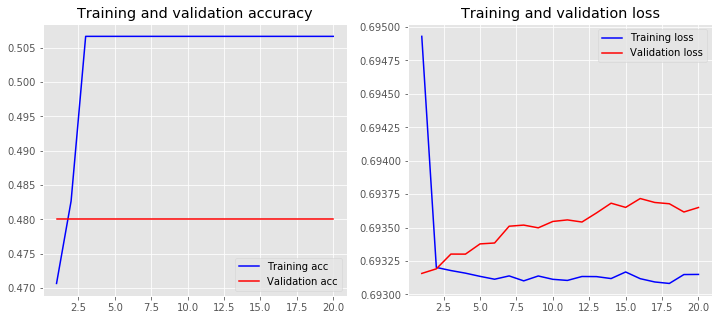

In [0]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_52 (Embedding)     (None, 100, 50)           87350     
_________________________________________________________________
global_max_pooling1d_47 (Glo (None, 50)                0         
_________________________________________________________________
dense_107 (Dense)            (None, 10)                510       
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 11        
Total params: 87,871
Trainable params: 87,871
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 1.0000
Testing Accuracy:  0.8240


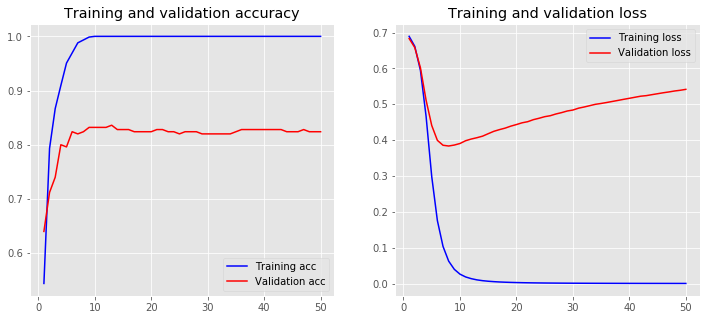

In [0]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim,
                           
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [0]:
! ls

 data		     glove.6B.300d.txt	 __MACOSX
 glove.6B.100d.txt   glove.6B.50d.txt	 sample_data
 glove.6B.200d.txt   glove.6B.zip	'sentiment labelled sentences.zip'


In [0]:
! head -n 1 glove.6B.50d.txt | cut -c-50

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.04445


In [0]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    'data/glove.6B.50d.txt',
    tokenizer.word_index, embedding_dim)

In [0]:

! ls cd data

ls: cannot access 'cd': No such file or directory
data:
glove.6B.50d.txt  output.txt  sentiment_analysis


Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_53 (Embedding)     (None, 100, 50)           87350     
_________________________________________________________________
global_max_pooling1d_48 (Glo (None, 50)                0         
_________________________________________________________________
dense_109 (Dense)            (None, 10)                510       
_________________________________________________________________
dense_110 (Dense)            (None, 1)                 11        
Total params: 87,871
Trainable params: 521
Non-trainable params: 87,350
_________________________________________________________________
Training Accuracy: 0.7667
Testing Accuracy:  0.6920


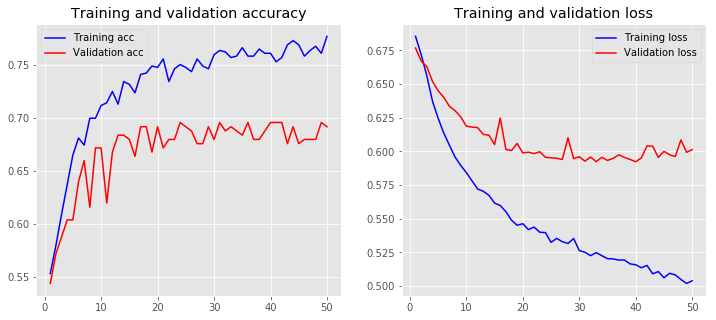

In [0]:
# pre-trained word embeddings
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_54 (Embedding)     (None, 100, 50)           87350     
_________________________________________________________________
global_max_pooling1d_49 (Glo (None, 50)                0         
_________________________________________________________________
dense_111 (Dense)            (None, 10)                510       
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 11        
Total params: 87,871
Trainable params: 87,871
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 1.0000
Testing Accuracy:  0.7880


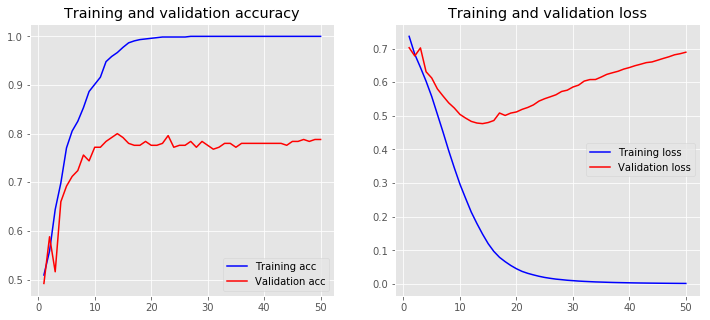

In [0]:
# trainable embeddings layer
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim,
                           weights=[embedding_matrix], 
                           input_length=maxlen,
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_55 (Embedding)     (None, 100, 100)          174700    
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_50 (Glo (None, 128)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 10)                1290      
_________________________________________________________________
dense_114 (Dense)            (None, 1)                 11        
Total params: 240,129
Trainable params: 240,129
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 1.0000
Testing Accuracy:  0.8000


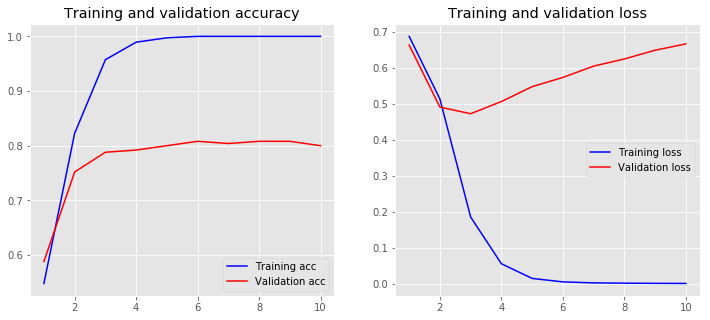

In [0]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [0]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
  
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    prompt = input(f'finished {source}; write to file and proceed? [y/n]')
    if prompt.lower() not in {'y', 'true', 'yes'}:
        break
    with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)

Running grid search for data set : amazon
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  7.1min finished


finished amazon; write to file and proceed? [y/n]y
Running amazon data set
Best Accuracy : 0.8137
{'vocab_size': 4603, 'num_filters': 32, 'maxlen': 100, 'kernel_size': 3, 'embedding_dim': 50}
Test Accuracy : 0.8297


Running grid search for data set : imdb
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  8.1min finished


KeyboardInterrupt: ignored